# GO term drift correlation

Tong Shu Li

We will try to find which GO terms correlate best with drift over time.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from collections import defaultdict
from scipy.stats import linregress
from scipy.stats import ttest_ind
from tqdm import tqdm

In [2]:
sys.path.append("../..")

In [3]:
from src.gene_ont import load_annotations
from src.gene_ont import parse_go_defn
from src.gene_ont import parse_go_links
from src.gene_ont import group_genes

In [4]:
%matplotlib inline

---

## Read filtered transcriptome data (36 samples)

In [5]:
data = pd.read_csv("../../data/PMID26623667/clean_annotated_cpm_values.tsv", sep = '\t')

In [6]:
data.shape

(391644, 13)

In [7]:
data.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,wormbaseid,gene_symbol
0,2RSSE.1,11,4.55942,1,1,1,water,0,1,4.105726,0.104814,WBGene00007064,2RSSE.1
1,2RSSE.1,12,3.21332,1,2,1,water,0,1,4.105726,-0.245078,WBGene00007064,2RSSE.1
2,2RSSE.1,13,4.54444,1,3,1,water,0,1,4.105726,0.101521,WBGene00007064,2RSSE.1
3,2RSSE.1,21,11.43680,2,1,3,water,0,1,4.105726,1.024454,WBGene00007064,2RSSE.1
4,2RSSE.1,22,4.77467,2,2,3,water,0,1,4.105726,0.150942,WBGene00007064,2RSSE.1


In [8]:
data["seqname"].nunique()

10879

---

## Extract time sequence samples without outliers (sample 6, replicate 2)

In [9]:
timeseries = data.query(
    "cohort <= 7 & samples != 62"
).assign(
    log_day = lambda df: np.log(df["day_harvested"])
)

In [10]:
# to make life easier for go term modeling later
# common reference for the same day whether normal or log value
mapping = {
    1: "A",
    3: "B",
    5: "C",
    10: "D"
}

timeseries["day_val"] = timeseries["day_harvested"].map(lambda v: mapping[v])

In [11]:
timeseries.shape

(217580, 15)

In [12]:
timeseries.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,wormbaseid,gene_symbol,log_day,day_val
0,2RSSE.1,11,4.55942,1,1,1,water,0,1,4.105726,0.104814,WBGene00007064,2RSSE.1,0.000000,A
1,2RSSE.1,12,3.21332,1,2,1,water,0,1,4.105726,-0.245078,WBGene00007064,2RSSE.1,0.000000,A
2,2RSSE.1,13,4.54444,1,3,1,water,0,1,4.105726,0.101521,WBGene00007064,2RSSE.1,0.000000,A
3,2RSSE.1,21,11.43680,2,1,3,water,0,1,4.105726,1.024454,WBGene00007064,2RSSE.1,1.098612,B
4,2RSSE.1,22,4.77467,2,2,3,water,0,1,4.105726,0.150942,WBGene00007064,2RSSE.1,1.098612,B


## Read GO data

### C. elegans annotations:

In [13]:
floc = "../../data/gene_ontology/gene_association.wb"
go_data = load_annotations(floc)

In [14]:
go_data.head()

,database_id,db_obj_symbol,qualifier,go_id,db_ref,evidence,with_from,aspect,db_obj_name,db_obj_syn,db_obj_type,taxon,date,assigned_by,annot_ext,gene_prod_id
0,WBGene00000001,aap-1,NaN,GO:0005623,WB_REF:WBPaper00005614|PMID:12393910,IDA,NaN,C,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
1,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000033,IBA,PANTHER:PTN000806614,C,NaN,Y110A7A.10,gene,taxon:6239,20150227,GO_Central,NaN,NaN
2,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000002,IEA,InterPro:IPR001720,C,NaN,Y110A7A.10,gene,taxon:6239,20150826,WB,NaN,NaN
3,WBGene00000001,aap-1,NaN,GO:0008286,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
4,WBGene00000001,aap-1,NaN,GO:0008340,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN


### GO definitions and hierarchy

In [15]:
go_defn = parse_go_defn("../../data/gene_ontology/go.obo")

In [16]:
fname = "../../data/gene_ontology/go.obo"
children = parse_go_links(fname)

### Genes annotated with each term

In [17]:
# save the gene names for each GO term
annots = defaultdict(
    set,
    {
        go_term: set(df["database_id"])
        for go_term, df in go_data.groupby("go_id")
    }
)

### Genes associated with each GO term (considering hierarchy)

In [18]:
go_groups = group_genes(children, annots, ["is_a", "part_of"])

---

## Hypothesis testing

We will calculate the drift for a sample using only the genes annotated with a GO term. Then we will create linear and log linear regressions and record some statistics about the results.

### Prepare GO terms to test

In [19]:
info = pd.DataFrame(
    [(go_term, len(genes)) for go_term, genes in go_groups.items()],
    columns = ["go_id", "num_genes"]
).pipe(
    pd.merge,
    go_defn, how = "inner", on = "go_id"
).drop(
    "obsolete", axis = 1
).query(
    "num_genes > 0"
).sort_values(
    "num_genes", ascending = False
).reset_index(
    drop = True
)

In [20]:
info.shape

(8042, 4)

In [21]:
info.head()

,go_id,num_genes,go_name,namespace
0,GO:0008150,11336,biological_process,biological_process
1,GO:0003674,8944,molecular_function,molecular_function
2,GO:0044699,8576,single-organism process,biological_process
3,GO:0005575,7895,cellular_component,cellular_component
4,GO:0009987,7233,cellular process,biological_process


In [22]:
good_genes = set(data["wormbaseid"])

info["num_in_data"] = info["go_id"].map(
    lambda v: len(good_genes & go_groups[v])
)

info = info.sort_values("num_in_data", ascending = False).reset_index(drop = True)
info["frac_present"] = info["num_in_data"] / info["num_genes"]

In [23]:
info = info.query("num_in_data >= 2")

In [24]:
info.shape

(5661, 6)

In [25]:
info.head()

,go_id,num_genes,go_name,namespace,num_in_data,frac_present
0,GO:0008150,11336,biological_process,biological_process,7120,0.628088
1,GO:0003674,8944,molecular_function,molecular_function,5816,0.650268
2,GO:0044699,8576,single-organism process,biological_process,5610,0.654151
3,GO:0005575,7895,cellular_component,cellular_component,5182,0.656365
4,GO:0009987,7233,cellular process,biological_process,4742,0.655606


---

## Modeling

In [26]:
def calc_drift(df):
    return df.groupby(
        [
            "cohort", "replicate", "drug",
            "day_harvested", "day_val", "log_day"
        ], as_index = False
    ).agg(
        {"RLFEC": np.var}
    ).rename(
        columns = {"RLFEC": "drift"}
    )

In [27]:
def get_reg_info(drift):
    """calculate parameters of the linear regressions"""

    def drift_stats(df):
        """determine the average variance of drift across multiple days"""
        
        temp = df.groupby("day_harvested")["drift"].var()
        return (temp.mean(), temp.var())

    
    models = {
        "linear": "day_harvested",
        "loglinear": "log_day"
    }    
    
    # fit linear regressions
    res = []
    for model, col in models.items():
        for drug, df in drift.groupby("drug"):
            
            slope, intercept, rval, pval, stderr = linregress(df[col], df["drift"])
            
            avg_var, var_var = drift_stats(df)
            
            res.append(
                (model, drug, slope, intercept, rval, pval, stderr,
                avg_var, var_var)
            )
    
    return pd.DataFrame(
        res, columns = [
            "model", "drug", "slope", "intercept", "rval", "pval", "stderr",
            "avg_drift_var", "var_drift_var"
        ]
    )

In [28]:
def get_model_info(drift, reg_info):
    mapping = {
        "linear": "day_harvested",
        "loglinear": "log_day"
    }
    
    res = []    
    for model, df in reg_info.groupby("model"):
        for day in "BCD":
            today = drift.query("day_val == '{}'".format(day))
            
            water = today.query("drug == 'water'")
            mian = today.query("drug == 'mianserin'")
            
            stat, pval = ttest_ind(water["drift"], mian["drift"], equal_var = False)
            
            # calculate gap between two regression lines
            # water minus mianserin
            x = today[mapping[model]].iloc[0]
            
            w_reg = df.query("drug == 'water'").iloc[0]
            m_reg = df.query("drug == 'mianserin'").iloc[0]
            
            w_y = w_reg["slope"] * x + w_reg["intercept"]
            m_y = m_reg["slope"] * x + m_reg["intercept"]
            
            gap = w_y - m_y
            
            
            res.append(
                (model, day, gap, pval)
            )
            
    return pd.DataFrame(res, columns = ["model", "day", "gap", "ttest_pval"])

In [29]:
def model(go_id):
    """Model results for a single go term."""
    
    # prepare data and calculate drift
    genes = pd.DataFrame(list(go_groups[go_id]), columns = ["wormbaseid"])
    
    sub = pd.merge(genes, timeseries, how = "left", on = "wormbaseid")
    drift = calc_drift(sub)
    
    
    reg_info = get_reg_info(drift).assign(go_id = go_id)
    
    model_info = get_model_info(drift, reg_info).assign(go_id = go_id)
    
    return (reg_info, model_info)

---

## Try it on all GO terms...

In [30]:
reg_info = []
model_info = []

for go_id in tqdm(info["go_id"]):
    reg, models = model(go_id)
    
    reg_info.append(reg)
    model_info.append(models)
    
reg_info = pd.concat(reg_info)
model_info = pd.concat(model_info)

100%|██████████| 5661/5661 [10:45<00:00,  8.70it/s]


In [31]:
reg_info.shape

(22644, 10)

In [32]:
model_info.shape

(33966, 5)

In [33]:
model_info.head()

,model,day,gap,ttest_pval,go_id
0,linear,B,0.144555,0.007185,GO:0008150
1,linear,C,0.202026,0.097997,GO:0008150
2,linear,D,0.345705,0.024644,GO:0008150
3,loglinear,B,0.230570,0.007185,GO:0008150
4,loglinear,C,0.261979,0.097997,GO:0008150


In [34]:
reg_info.head()

,model,drug,slope,intercept,rval,pval,stderr,avg_drift_var,var_drift_var,go_id
0,linear,mianserin,0.038724,0.113557,0.913624,1.508497e-03,0.007035,0.004267,0.000005,GO:0008150
1,linear,water,0.067460,0.171904,0.893372,9.053622e-05,0.010729,0.004311,0.000025,GO:0008150
2,loglinear,mianserin,0.231556,-0.037763,0.921402,1.143443e-03,0.039870,0.004267,0.000005,GO:0008150
3,loglinear,water,0.293042,0.125258,0.974624,7.942114e-08,0.021284,0.004311,0.000025,GO:0008150
0,linear,mianserin,0.037832,0.124857,0.912133,1.586190e-03,0.006941,0.003997,0.000004,GO:0003674


In [35]:
model_info.to_csv("model_info.tsv", sep = '\t', index = False)

In [36]:
reg_info.to_csv("reg_info.tsv", sep = '\t', index = False)

---

## Examine results

In [37]:
model_info["go_id"].nunique()

5661

## Number of GO terms with significant gaps between the mean drift values at days 3, 5, and 10

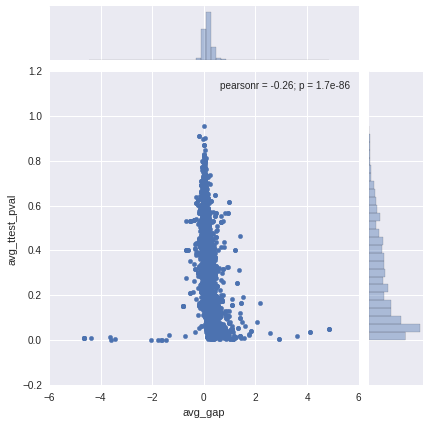

In [38]:
avgs = (
    model_info.query("model == 'linear'")
        .groupby("go_id")
        .agg(np.mean)
        .rename(columns = {
            "gap": "avg_gap",
            "ttest_pval": "avg_ttest_pval"
        })
)

sns.jointplot(
    data = avgs,
    x = "avg_gap",
    y = "avg_ttest_pval"
);

### Just the significant ones (p < 0.05)

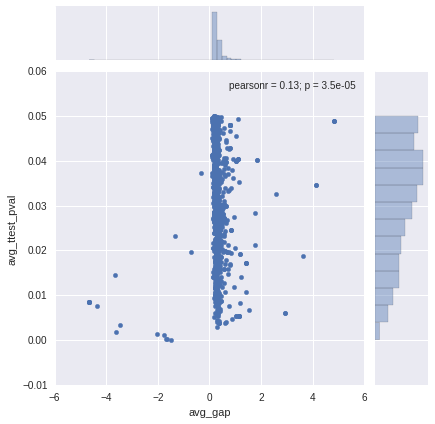

In [39]:
sns.jointplot(
    data = avgs.query("avg_ttest_pval < 0.05"),
    x = "avg_gap",
    y = "avg_ttest_pval"
);

## Grab the models which have significant gaps at days 3, 5, 10

In [40]:
signif_models = (
    model_info.groupby(["go_id", "model"], as_index = False)
        .filter(lambda df: (df['ttest_pval'] < 0.05).all())
)

In [41]:
signif_models.shape

(2274, 5)

In [42]:
signif_models.head()

,model,day,gap,ttest_pval,go_id
0,linear,B,0.187222,0.004938,GO:0016020
1,linear,C,0.259101,0.043509,GO:0016020
2,linear,D,0.438798,0.028676,GO:0016020
3,loglinear,B,0.274837,0.004938,GO:0016020
4,loglinear,C,0.326560,0.043509,GO:0016020


## For the GO terms which had significant gaps, what were the terms, and how many genes do they contain?

In [43]:
good_metadata = pd.merge(
    signif_models["go_id"].drop_duplicates().to_frame(), info,
    how = "left", on = "go_id"
)

In [44]:
good_metadata.shape

(379, 6)

In [45]:
good_metadata.head()

,go_id,num_genes,go_name,namespace,num_in_data,frac_present
0,GO:0016020,3380,membrane,cellular_component,1759,0.520414
1,GO:0005515,1757,protein binding,molecular_function,1444,0.821855
2,GO:0044425,2889,membrane part,cellular_component,1440,0.498442
3,GO:0048518,1055,positive regulation of biological process,biological_process,811,0.768720
4,GO:0048468,862,cell development,biological_process,682,0.791183


## For the 379 significant GO terms, how many genes per term?

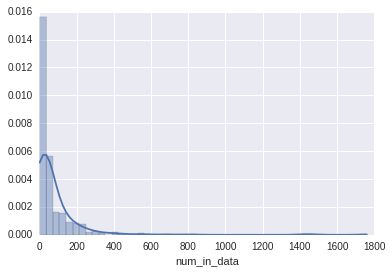

In [46]:
sns.distplot(good_metadata["num_in_data"])

#### So mostly GO terms with a few genes

## Examine the significant go terms with 10 to 100 genes

In [47]:
good_metadata.head()

,go_id,num_genes,go_name,namespace,num_in_data,frac_present
0,GO:0016020,3380,membrane,cellular_component,1759,0.520414
1,GO:0005515,1757,protein binding,molecular_function,1444,0.821855
2,GO:0044425,2889,membrane part,cellular_component,1440,0.498442
3,GO:0048518,1055,positive regulation of biological process,biological_process,811,0.768720
4,GO:0048468,862,cell development,biological_process,682,0.791183


In [48]:
small = good_metadata.query("10 <= num_in_data <= 100")[["go_id", "go_name", "num_in_data"]]

## Look at gap size with number of genes

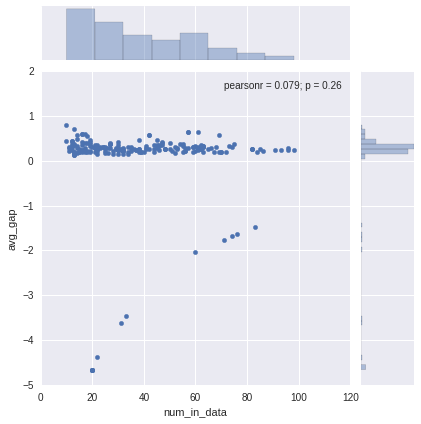

In [49]:
temp = pd.merge(
    avgs.reset_index(), small,
    how = "right", on = "go_id"
)

sns.jointplot(
    data = temp,
    x = "num_in_data",
    y = "avg_gap"
);

Looks like the water data has more drift for almost all of the GO terms here, but some have the mianserin with higher drift (gap size < 0).

## Look at only the positive gap sizes

In [53]:
best = temp.query("avg_gap > 0")

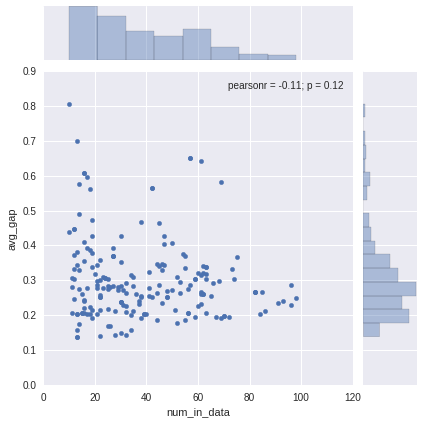

In [54]:
sns.jointplot(
    data = best,
    x = "num_in_data",
    y = "avg_gap"
);

## Look at the models themselves now

In [67]:
best_reg = pd.merge(best, reg_info, how = "left", on = "go_id")

In [72]:
best_reg.sort_values("rval", ascending = False).head()

,go_id,avg_gap,avg_ttest_pval,go_name,num_in_data,model,drug,slope,intercept,rval,pval,stderr,avg_drift_var,var_drift_var
30,GO:0000981,0.270775,0.013167,RNA polymerase II transcription factor activit...,50,loglinear,mianserin,0.201083,-0.078489,0.989786,2.643602e-06,0.011824,0.000451,3.432906e-07
308,GO:0016798,0.582698,0.003765,"hydrolase activity, acting on glycosyl bonds",69,linear,mianserin,0.157812,-0.308893,0.988309,3.959612e-06,0.009939,0.003575,1.086123e-05
76,GO:0004553,0.641491,0.004042,"hydrolase activity, hydrolyzing O-glycosyl com...",61,linear,mianserin,0.176128,-0.351760,0.986853,5.625663e-06,0.011776,0.004781,2.124851e-05
77,GO:0004553,0.641491,0.004042,"hydrolase activity, hydrolyzing O-glycosyl com...",61,linear,water,0.224813,-0.002379,0.986397,3.584888e-09,0.011847,0.011213,7.071847e-05
309,GO:0016798,0.582698,0.003765,"hydrolase activity, acting on glycosyl bonds",69,linear,water,0.201550,0.011374,0.985439,5.031452e-09,0.010997,0.009378,7.600605e-05


In [79]:
res = (
    best_reg.groupby(["model", "go_id"], as_index = False).agg(
        np.mean
    )[["go_id", "model", "num_in_data", "rval", "pval", "avg_drift_var", "var_drift_var"]]
        .sort_values("rval", ascending = False)
)

res = pd.merge(res, info[["go_id", "go_name"]], how = "left", on = "go_id")

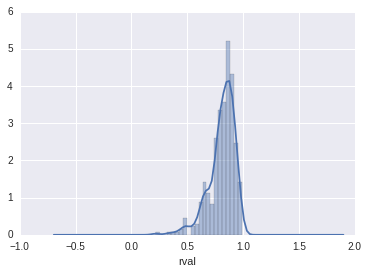

In [81]:
sns.distplot(res["rval"])

In [82]:
res.query("rval > 0.8")

,go_id,model,num_in_data,rval,pval,avg_drift_var,var_drift_var,go_name
0,GO:0016798,linear,69,0.986874,0.000002,0.006476,4.343364e-05,"hydrolase activity, acting on glycosyl bonds"
1,GO:0004553,linear,61,0.986625,0.000003,0.007997,4.598349e-05,"hydrolase activity, hydrolyzing O-glycosyl com..."
2,GO:0016597,loglinear,14,0.973689,0.000014,0.009955,2.788921e-04,amino acid binding
3,GO:0031406,loglinear,24,0.970329,0.000014,0.004526,4.896386e-05,carboxylic acid binding
4,GO:0043177,loglinear,24,0.970329,0.000014,0.004526,4.896386e-05,organic acid binding
5,GO:0016798,loglinear,69,0.964101,0.000056,0.006476,4.343364e-05,"hydrolase activity, acting on glycosyl bonds"
6,GO:0034728,loglinear,18,0.963145,0.000099,0.001698,2.196705e-06,nucleosome organization
7,GO:0004553,loglinear,61,0.962285,0.000069,0.007997,4.598349e-05,"hydrolase activity, hydrolyzing O-glycosyl com..."
8,GO:0051236,linear,30,0.961312,0.000145,0.003035,2.271821e-05,establishment of RNA localization
9,GO:0050658,linear,30,0.961312,0.000145,0.003035,2.271821e-05,RNA transport


In [80]:
res

,go_id,model,num_in_data,rval,pval,avg_drift_var,var_drift_var,go_name
0,GO:0016798,linear,69,0.986874,0.000002,0.006476,4.343364e-05,"hydrolase activity, acting on glycosyl bonds"
1,GO:0004553,linear,61,0.986625,0.000003,0.007997,4.598349e-05,"hydrolase activity, hydrolyzing O-glycosyl com..."
2,GO:0016597,loglinear,14,0.973689,0.000014,0.009955,2.788921e-04,amino acid binding
3,GO:0031406,loglinear,24,0.970329,0.000014,0.004526,4.896386e-05,carboxylic acid binding
4,GO:0043177,loglinear,24,0.970329,0.000014,0.004526,4.896386e-05,organic acid binding
5,GO:0016798,loglinear,69,0.964101,0.000056,0.006476,4.343364e-05,"hydrolase activity, acting on glycosyl bonds"
6,GO:0034728,loglinear,18,0.963145,0.000099,0.001698,2.196705e-06,nucleosome organization
7,GO:0004553,loglinear,61,0.962285,0.000069,0.007997,4.598349e-05,"hydrolase activity, hydrolyzing O-glycosyl com..."
8,GO:0051236,linear,30,0.961312,0.000145,0.003035,2.271821e-05,establishment of RNA localization
9,GO:0050658,linear,30,0.961312,0.000145,0.003035,2.271821e-05,RNA transport


In [77]:
reg_info.query("go_id == 'GO:0016798'")

,model,drug,slope,intercept,rval,pval,stderr,avg_drift_var,var_drift_var,go_id
0,linear,mianserin,0.157812,-0.308893,0.988309,3.959612e-06,0.009939,0.003575,0.000011,GO:0016798
1,linear,water,0.201550,0.011374,0.985439,5.031452e-09,0.010997,0.009378,0.000076,GO:0016798
2,loglinear,mianserin,0.912908,-0.873981,0.964254,1.111481e-04,0.102417,0.003575,0.000011,GO:0016798
3,loglinear,water,0.785028,-0.014635,0.963948,4.514767e-07,0.068527,0.009378,0.000076,GO:0016798


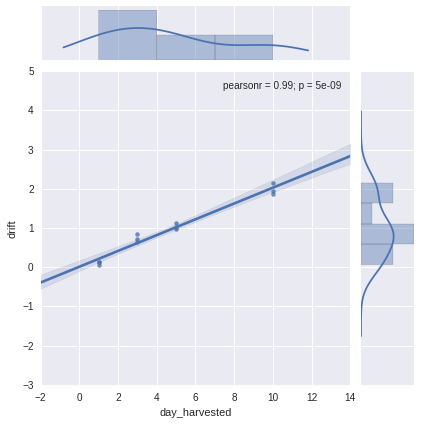

In [78]:
sns.jointplot(
    data = yolo("GO:0016798").query("drug == 'water'"),
    x = "day_harvested", y = "drift",
    kind = "reg"
);

In [75]:
def yolo(go_id):
    """Model results for a single go term."""
    
    # prepare data and calculate drift
    genes = pd.DataFrame(list(go_groups[go_id]), columns = ["wormbaseid"])
    
    sub = pd.merge(genes, timeseries, how = "left", on = "wormbaseid")
    return calc_drift(sub)

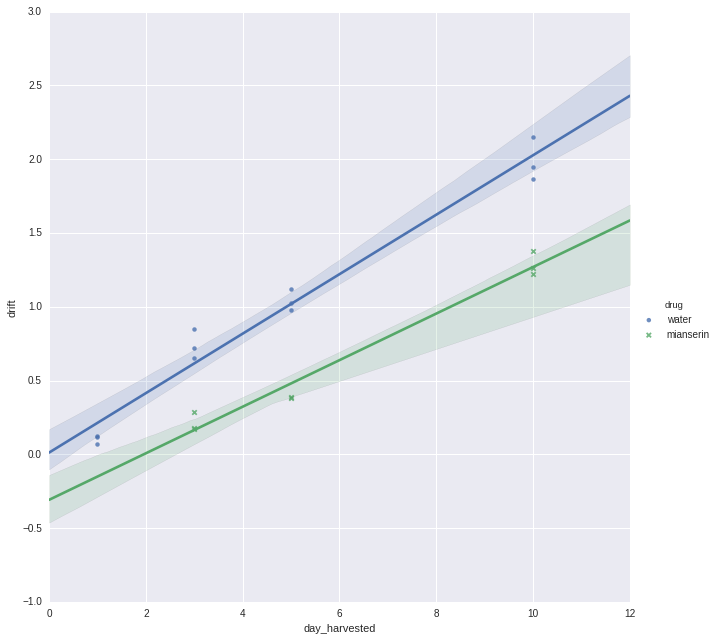

In [76]:
term = "GO:0016798"

def plot(term, model):
    res = yolo(term)

    sns.lmplot(
        data = res,
        x = model, y = "drift",
        hue = "drug", size = 9, markers = ['o', 'x']
    );
    
plot(term, "day_harvested")

## At this point we should cross correlate with other datasets

## Need a better definition of the metrics we'll use to evaluate these linear models